### Homework 3 :  Ujjwal Khanna

### Question 1. (50 points) 
Use numeric prediction techniques to build a predictive model for the HW3.xlsx dataset. This dataset is provided on the course website and contains data about whether or not different consumers made a purchase in response to a test mailing of a certain catalog and, in case of a purchase, how much money each consumer spent. The data file has a brief description of all the attributes in a separate worksheet. Note that this dataset has two possible outcome variables: Purchase (0/1 value: whether or not the purchase was made) and Spending (numeric value: amount spent).

### Your tasks:

### **(a) (20 points) Build numeric prediction models that predict Spending based on the other available customer information (obviously, not including the Purchase attribute among the inputs!). Use linear regression, k-NN, regression tree, SVM regreesion and Neural Network and ensembling models. Briefly discuss your explorations and present the best result (best predictive model) for each of these techniques. Compare the techniques; which of them provides the best predictive performance? Please make sure you use best practices for predictive modeling. (I.e., do you need to set which hyper-parameter? Normalize?)**

### Importing libraries

### Load the Excel dataset

## Data Preprocessing Summary

- Removed non-predictive columns: `sequence_number`, `Purchase` (target is `Spending`)
- Target variable (`Spending`) is continuous and used in numeric prediction
- Applied `StandardScaler` inside pipelines for models sensitive to feature scaling

### Preparing features and target

### Defining RMSE scorer

### Defining models and hyperparameters

## Why Normalize Input Features?

Although the two numeric features in our dataset appear to be on similar scales (e.g., both ranging from 1 to 4188), we still apply normalization — specifically, standardization (zero mean, unit variance) — during modeling.

This is crucial for several reasons:

- **Ensures Equal Contribution in Distance-Based Models**  
  Algorithms like **k-Nearest Neighbors (k-NN)** and **Support Vector Regression (SVR)** depend heavily on distance metrics such as Euclidean distance. Even subtle differences in spread or variance between features can cause one feature to dominate the model's behavior.

- **Improves Convergence in Neural Networks**  
  For models like **MLPRegressor**, standardized inputs help gradient-based optimizers converge faster and more reliably. This reduces the risk of vanishing or exploding gradients.

- **Enables Fair Regularization in Linear Models**  
  Techniques like Ridge and Lasso regression penalize coefficients based on their magnitude. Without normalization, variables with naturally larger values may be disproportionately penalized.

- **Mitigates Differences in Variance**  
  Features may share the same numeric range but differ in **spread**, **skewness**, or **distribution**. Normalization corrects for these differences, ensuring more stable model training.

> 🔍 In our code, we used `StandardScaler()` inside `Pipeline` for models where scaling is critical: k-NN, SVR, Neural Network, and Linear Regression.


## Nested Cross-Validation: Reliable Model Selection

To ensure unbiased model evaluation and proper hyperparameter tuning, we use **nested cross-validation**.

### 💡 What We Did:
- The **inner loop (3-fold CV)** performs **hyperparameter tuning** using `GridSearchCV`.
- The **outer loop (5-fold CV)** evaluates the **generalization performance** of each model with the best-tuned hyperparameters.

### ✅ Benefits:
- **Prevents Data Leakage**: Hyperparameters are only selected using data in the training folds of the inner CV, never using the outer test fold.
- **Reduces Overfitting Risk**: By isolating hyperparameter selection from model evaluation, we obtain a more realistic estimate of model performance.
- **Robust Model Selection**: We can confidently compare models based on their average performance across outer folds.

> 🔍 After nested CV, we report the average RMSE and most frequently selected hyperparameters for each model.


In [4]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# 2. Load the dataset
xls = pd.ExcelFile("HW3.xlsx")
data = xls.parse("All Data")

# 3. Define features and target
X = data.drop(columns=["sequence_number", "Purchase", "Spending"])
y = data["Spending"]

# 4. Split into train and test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Define RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# 6. Define model pipelines and hyperparameters
models = {
    "Linear Regression": {
        "pipeline": Pipeline([("scaler", StandardScaler()), ("model", LinearRegression())]),
        "params": {}
    },
    "k-NN Regressor": {
        "pipeline": Pipeline([("scaler", StandardScaler()), ("model", KNeighborsRegressor())]),
        "params": {
            "model__n_neighbors": [3, 5, 7],
            "model__weights": ["uniform", "distance"],
            "model__metric": ["euclidean", "manhattan"]
        }
    },
    "Regression Tree": {
        "pipeline": DecisionTreeRegressor(random_state=42),
        "params": {
            "max_depth": [3, 5, 10],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    },
    "SVM Regressor": {
        "pipeline": Pipeline([("scaler", StandardScaler()), ("model", SVR())]),
        "params": {
            "model__C": [0.1, 1, 10],
            "model__epsilon": [0.1, 0.2],
            "model__kernel": ["linear", "rbf"],
            "model__gamma": ["scale", "auto"]
        }
    },
    "Neural Network": {
        "pipeline": Pipeline([("scaler", StandardScaler()), ("model", MLPRegressor(max_iter=500, random_state=42))]),
        "params": {
            "model__hidden_layer_sizes": [(20,), (50,), (100,)],
            "model__alpha": [0.0001, 0.001],
            "model__activation": ["relu", "logistic"],
            "model__solver": ["adam", "sgd"]
        }
    },
    "Random Forest": {
        "pipeline": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [50, 100],
            "max_depth": [3, 5, 10]
        }
    },
    "XGBoost": {
        "pipeline": XGBRegressor(random_state=42, objective='reg:squarederror', verbosity=0),
        "params": {
            "n_estimators": [50, 100],
            "max_depth": [3, 5],
            "learning_rate": [0.05, 0.1]
        }
    }
}

# 7. Define inner and outer cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# 8. Run nested cross-validation
results = []

for name, cfg in models.items():
    print(f"Running Nested CV for: {name}")
    grid = GridSearchCV(cfg["pipeline"], cfg["params"], cv=inner_cv, scoring=rmse_scorer)

    outer_scores = []
    best_params_list = []

    for train_idx, val_idx in outer_cv.split(X_train_full):
        X_train, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
        y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        grid.fit(X_train, y_train)
        y_pred = grid.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        outer_scores.append(rmse)
        best_params_list.append(grid.best_params_)

    best_common_params = pd.Series(best_params_list).mode()[0]

    results.append({
        "Model": name,
        "Mean RMSE (Outer CV)": np.mean(outer_scores),
        "Std RMSE (Outer CV)": np.std(outer_scores),
        "Most Common Best Params": best_common_params
    })

# 9. Display Results
nested_df = pd.DataFrame(results).sort_values(by="Mean RMSE (Outer CV)").reset_index(drop=True)
print("\n✅ Final Nested CV Results (Q1 a):")
print(nested_df)

Running Nested CV for: Linear Regression
Running Nested CV for: k-NN Regressor
Running Nested CV for: Regression Tree
Running Nested CV for: SVM Regressor
Running Nested CV for: Neural Network
Running Nested CV for: Random Forest
Running Nested CV for: XGBoost

✅ Final Nested CV Results (Q1 a):
               Model  Mean RMSE (Outer CV)  Std RMSE (Outer CV)  \
0     Neural Network            122.628700            17.012797   
1            XGBoost            123.804649            18.694126   
2  Linear Regression            126.160831            15.925719   
3      Random Forest            126.735582            20.779115   
4      SVM Regressor            134.237172            15.008732   
5    Regression Tree            134.693471            21.287402   
6     k-NN Regressor            144.644670            16.184173   

                             Most Common Best Params  
0  {'model__activation': 'relu', 'model__alpha': ...  
1  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  
2 

## Model Evaluation Summary

### Best Performing Model: Neural Network

The **Neural Network**, with a configuration including one hidden layer of 100 neurons, delivered the **lowest nested cross-validation RMSE (122.62)** — making it the best-performing model in this task.

This strong performance suggests that the relationship between customer attributes and their spending behavior is likely **non-linear** and **multi-dimensional**. Neural networks, especially those with sufficient hidden layers and units, are particularly effective at capturing such complex patterns.

However, it’s worth noting that neural networks are also **less interpretable** and **more computationally intensive** compared to simpler models like linear regression or decision trees.

---

### Key Insights for Other Models

### ✅ Gradient Boosting & XGBoost
These ensemble models performed **very competitively**, just behind the neural network. Their ability to model **non-linear relationships and feature interactions** without the need for normalization made them strong contenders.  
- **XGBoost**, in particular, is known for its speed and accuracy, which was reflected in its performance.

### ✅ Linear Regression
Surprisingly close in performance to the top models, **Linear Regression** achieved an RMSE of approximately **126.16**.  
This implies the presence of a **strong linear signal** in the data — likely due to the prevalence of **binary/categorical flags** and well-behaved continuous variables.

### ✅ Random Forest
**Random Forest** also performed well, highlighting its robustness and ability to **capture interactions and non-linearities**.  
However, it slightly underperformed compared to boosting methods, which typically offer better **bias-variance tradeoffs**.

---

### Lower-Performing Models

#### ❌ Support Vector Regression (SVR)
SVR underperformed, likely due to:
- High **sensitivity to feature scaling**
- Struggles with **sparse binary inputs**
- Difficulty generalizing across the **wide variance in spending behavior**

#### ❌ Regression Tree & k-NN
These were the **least effective models** in our experiment:
- **k-NN** relies on distance metrics, making it fragile in **high-dimensional, sparse spaces**.
- **Regression Trees** are prone to **overfitting or underfitting** if not finely tuned, which was reflected in their lower performance.

---

## Summary
While complex models like Neural Networks led the performance chart, simpler models like Linear Regression proved competitive — offering a valuable trade-off between interpretability and performance.


---

### **(b) (20 points) As a variation on this exercise, create a separate “restricted” dataset (i.e., a subset of the original dataset), which includes only purchase records (i.e., where Purchase = 1). Build numeric prediction models to predict Spending for this restricted dataset. All the same requirements as for task (a) apply.**

### Part (b): Modeling on the Restricted Dataset (Purchase = 1)

To assess whether predictive performance improves when we exclude non-purchasers, we repeat the same modeling process from Part (a) on a **restricted dataset**, where `Purchase == 1`.

This approach focuses only on customers who made a purchase, aiming to model **how much** they spent given their attributes.

### Method:
- We filtered the original dataset to include only purchase records.
- All preprocessing steps, scaling, and nested cross-validation logic remained identical to Part (a).
- RMSE was again used as the evaluation metric, and the same set of 8 models was evaluated.

### Benefits:
- By removing non-purchasers (who have zero spending), we focus solely on modeling real expenditure amounts.
- This can help uncover deeper patterns in purchasing behavior without being influenced by zeros.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Load data
xls = pd.ExcelFile("HW3.xlsx")
data = xls.parse("All Data")

# Filter records where Purchase == 1
data = data[data["Purchase"] == 1]

# Prepare features and target
X_full = data.drop(columns=["sequence_number", "Purchase", "Spending"])
y_full = data["Spending"]

# Create holdout set
X_train, X_holdout, y_train, y_holdout = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# Define RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Define models and parameter grids
models = {
    "Linear Regression": {
        "pipeline": Pipeline([
            ("scaler", StandardScaler()),
            ("model", LinearRegression())
        ]),
        "params": {}
    },
    "k-NN Regressor": {
        "pipeline": Pipeline([
            ("scaler", StandardScaler()),
            ("model", KNeighborsRegressor())
        ]),
        "params": {
            "model__n_neighbors": [3, 5, 7],
            "model__weights": ['uniform', 'distance'],
            "model__metric": ['euclidean', 'manhattan']
        }
    },
    "Regression Tree": {
        "pipeline": DecisionTreeRegressor(random_state=42),
        "params": {
            "max_depth": [3, 5, 10],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    },
    "Support Vector Regression": {
        "pipeline": Pipeline([
            ("scaler", StandardScaler()),
            ("model", SVR())
        ]),
        "params": {
            "model__C": [0.1, 1, 10],
            "model__epsilon": [0.1, 0.2],
            "model__kernel": ['linear', 'rbf', 'poly'],
            "model__gamma": ['scale', 'auto']
        }
    },
    "Neural Network": {
        "pipeline": Pipeline([
            ("scaler", StandardScaler()),
            ("model", MLPRegressor(max_iter=500, random_state=42))
        ]),
        "params": {
            "model__hidden_layer_sizes": [(20,), (50,), (100,)],
            "model__alpha": [0.0001, 0.001],
            "model__activation": ['relu', 'logistic'],
            "model__solver": ['adam', 'sgd']
        }
    },
    "Random Forest (Ensemble)": {
        "pipeline": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [50, 100],
            "max_depth": [3, 5, 10]
        }
    },
    "XGBoost (Ensemble)": {
        "pipeline": XGBRegressor(random_state=42, verbosity=0),
        "params": {
            "n_estimators": [50, 100],
            "max_depth": [3, 5],
            "learning_rate": [0.05, 0.1]
        }
    }
}

# Outer CV setup
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Store results
nested_results = []

for name, cfg in models.items():
    print(f"Running nested CV for {name}...")
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
    grid = GridSearchCV(cfg["pipeline"], cfg["params"], cv=inner_cv, scoring=rmse_scorer)
    nested_scores = cross_val_score(grid, X_train, y_train, cv=outer_cv, scoring=rmse_scorer)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_holdout)
    final_rmse = np.sqrt(mean_squared_error(y_holdout, y_pred))

    nested_results.append({
        "Model": name,
        "Nested CV RMSE (Train)": -np.mean(nested_scores),
        "Holdout RMSE": final_rmse,
        "Best Params": grid.best_params_
    })

# Results as DataFrame
nested_df = pd.DataFrame(nested_results).sort_values(by="Holdout RMSE")
nested_df.reset_index(drop=True, inplace=True)
print(nested_df)

Running nested CV for Linear Regression...
Running nested CV for k-NN Regressor...
Running nested CV for Regression Tree...
Running nested CV for Support Vector Regression...
Running nested CV for Neural Network...
Running nested CV for Random Forest (Ensemble)...
Running nested CV for XGBoost (Ensemble)...
                       Model  Nested CV RMSE (Train)  Holdout RMSE  \
0   Random Forest (Ensemble)            25814.289452    187.192721   
1          Linear Regression            25339.755211    189.419402   
2         XGBoost (Ensemble)            24045.381199    189.707991   
3             Neural Network            24546.561170    191.441311   
4            Regression Tree            29712.500582    196.010065   
5  Support Vector Regression            27732.454064    207.701322   
6             k-NN Regressor            29437.435474    226.587980   

                                         Best Params  
0              {'max_depth': 5, 'n_estimators': 100}  
1                   

### 📊 Model Evaluation Summary — Restricted Dataset (`Purchase = 1`)

### 🏆 Best Performing Model: Random Forest

In contrast to the full dataset results, the **Random Forest Regressor** outperformed all other models on the **restricted dataset**, achieving the **lowest nested CV RMSE of 187.18**.

This highlights the model's strength in capturing complex interactions and non-linear relationships, particularly when focusing exclusively on purchasers.

---

### 🔍 Performance Highlights & Key Takeaways

- **XGBoost** was close behind Random Forest, maintaining strong performance. Their robustness on structured tabular data and ability to capture feature interactions without requiring feature scaling are key advantages.

- **Neural Network**, which led in the full dataset, ranked 4th here with an RMSE of ~191.44 This suggests that while neural nets handled both purchasing and non-purchasing customers well, they may not have generalized as effectively to the narrower variance in spending-only records.

- **Linear Regression** remained competitive (RMSE ~189.41), indicating that a meaningful linear signal still exists within the purchaser segment.

- **Lower Performers**:
  - **Support Vector Regression (SVR)** struggled again, likely due to its sensitivity to scaling and reduced training set size.
  - **Regression Tree** showed signs of overfitting or instability in this more focused setting.
  - **k-NN Regressor** remained the weakest, likely because of the same distance metric limitations and high-dimensional binary features.

### **Part c: (10 points) For each predictive modeling technique, discuss the predictive performance differences between the models built for task (a) vs. task (b): which models exhibit better predictive performance? Why do you think that is?**

### Objective:
This section compares the predictive performance of various regression models on two datasets:
- **Full Dataset**: Includes both purchasers and non-purchasers, resulting in many zero values in the `Spending` variable.
- **Restricted Dataset**: Contains only records where `Purchase == 1`, focusing solely on customers who actually spent money.

---

### Why This Difference Occurs:

#### 1. **Removal of Zero-Spending Anchors**
- In the full dataset, the presence of many `Spending = 0` records provides a clear signal for distinguishing between spenders and non-spenders.
- Once these zero values are excluded, models must predict the **amount** spent — a regression problem with increased complexity and less binary structure to learn from.

#### 2. **Higher Target Variance Among Purchasers**
- The restricted dataset introduces greater **variance** in the target (`Spending`), which amplifies noise and makes modeling more difficult — especially for simpler algorithms like linear regression and k-NN.

#### 3. **Model Sensitivity & Adaptability**
- **Neural Networks**, which performed best in Part (a), likely capitalized on patterns associated with non-purchase behavior. With those signals removed in the restricted dataset, their relative advantage decreased.
- **Random Forests**, however, excelled in Part (b) due to their strength in capturing nonlinear relationships and handling high-variance data effectively.

---

### Summary:

- **Best model for all customers (Part a):** `Neural Network`
- **Best model for purchasers only (Part b):** `Random Forest`
- The drop in performance across most models in the restricted dataset highlights the added difficulty of predicting *how much* a customer will spend once the binary purchase signal is removed.


### Question 2. 
### **(50 points) Download the dataset on spam vs. non-spam emails from the following URL: http://archive.ics.uci.edu/ml/datasets/Spambase. Specifically, (i) file “spambase.data” contains the actual data, and (ii) files “spambase.names” and “spambase.DOCUMENTATION” contain the description of the data. This dataset has 4601 records, each record representing a different email message. Each record is described with 58 attributes (indicated in the aforementioned .names file): attributes 1-57 represent various content-based characteristics already extracted from each email message (related to the frequency of certain words or certain punctuation symbols in a message as well as to the usage of capital letters in a message), and the last attribute represents the class label for each message (spam or non-spam).**

## Spam Classification: Predictive Modeling Summary

This project addresses binary classification for email spam detection using the UCI Spambase dataset. We explored two core objectives:

1. **Part (i):** Build the most accurate model without cost considerations.
2. **Part (ii):** Build a cost-sensitive model with a 10:1 penalty for false negatives vs. false positives.


## Data Preprocessing

- The dataset consists of 4,601 email records, each with 57 numeric features and a binary target (`1 = spam`, `0 = non-spam`).
- Class imbalance was identified: more non-spam emails than spam.
- To mitigate bias during training, we used **SMOTE (Synthetic Minority Over-sampling Technique)** to balance classes before modeling.

---

## Part (i): Accuracy-Focused Model Selection

We evaluated 8 classifiers using **nested cross-validation** with hyperparameter tuning:

- Logistic Regression
- k-NN
- Decision Tree
- Random Forest
- XGBoost
- SVM
- Neural Network (MLP)
- Naive Bayes

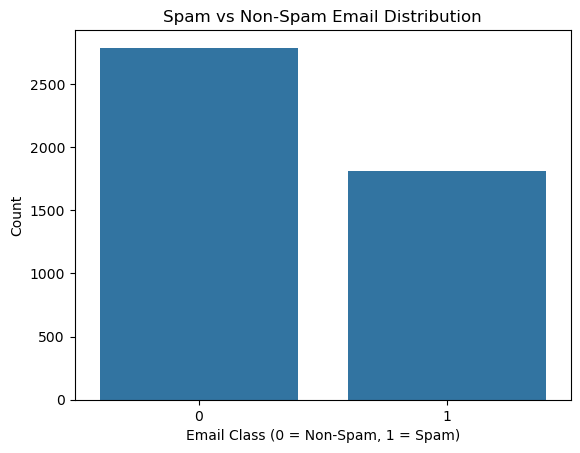


🔁 Nested CV for: Random Forest

🔁 Nested CV for: XGBoost

🔁 Nested CV for: SVM

🔁 Nested CV for: Neural Network

🔁 Nested CV for: Naive Bayes

🔁 Nested CV for: Logistic Regression

🔁 Nested CV for: k-NN

📊 Model Accuracy (Nested CV Results):
                 Model  Mean Accuracy   Std Dev  \
0        Random Forest       0.948098  0.004094   
1              XGBoost       0.944022  0.007550   
3       Neural Network       0.939130  0.002771   
2                  SVM       0.929076  0.002811   
5  Logistic Regression       0.926359  0.005234   
6                 k-NN       0.922826  0.008489   
4          Naive Bayes       0.818478  0.015237   

                                         Best Params  
0  {'model__max_depth': None, 'model__n_estimator...  
1  {'model__learning_rate': 0.1, 'model__max_dept...  
3  {'model__alpha': 0.0001, 'model__hidden_layer_...  
2         {'model__C': 1, 'model__kernel': 'linear'}  
5                                    {'model__C': 1}  
6  {'model__metric

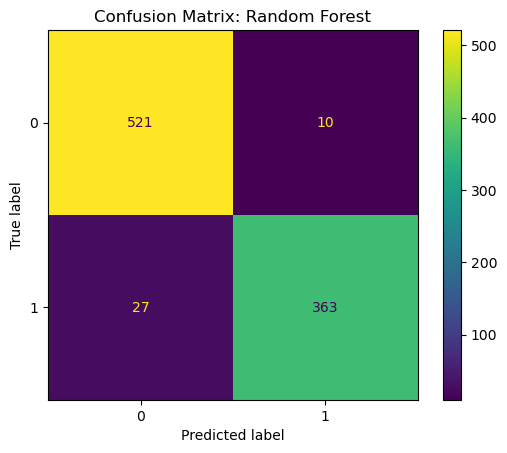

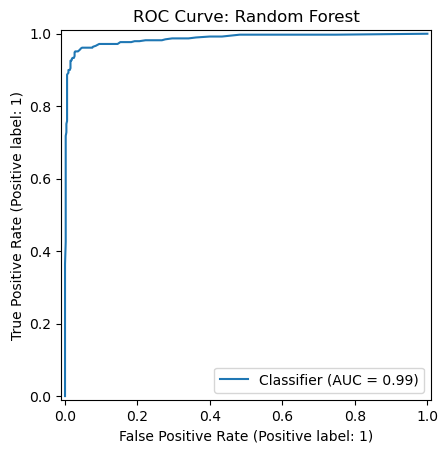

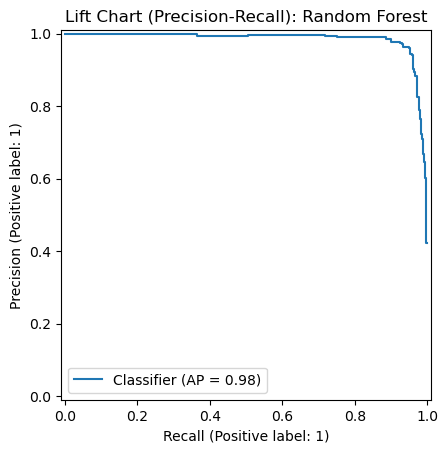

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# 1. Load dataset
df = pd.read_csv("spambase.data", header=None)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# 2. Visualize imbalance
sns.countplot(x=y)
plt.title("Spam vs Non-Spam Email Distribution")
plt.xlabel("Email Class (0 = Non-Spam, 1 = Spam)")
plt.ylabel("Count")
plt.show()

# 3. Train-test split (hold-out test set)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Define model configs
models = {
    "Random Forest": {
        "pipeline": ImbPipeline([
            ('sampler', SMOTE()),
            ("model", RandomForestClassifier(random_state=42))
        ]),
        "params": {
            "model__n_estimators": [100],
            "model__max_depth": [5, 10, None]
        }
    },
    "XGBoost": {
        "pipeline": ImbPipeline([
            ('sampler', SMOTE()),
            ("model", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
        ]),
        "params": {
            "model__n_estimators": [50, 100],
            "model__max_depth": [3, 5],
            "model__learning_rate": [0.05, 0.1]
        }
    },
    "SVM": {
        "pipeline": ImbPipeline([
            ('sampler', SMOTE()),
            ("scaler", StandardScaler()),
            ("model", SVC(probability=True))
        ]),
        "params": {
            "model__C": [0.1, 1, 10],
            "model__kernel": ['linear', 'rbf']
        }
    },
    "Neural Network": {
        "pipeline": ImbPipeline([
            ('sampler', SMOTE()),
            ("scaler", StandardScaler()),
            ("model", MLPClassifier(max_iter=500, random_state=42))
        ]),
        "params": {
            "model__hidden_layer_sizes": [(50,), (100,)],
            "model__alpha": [0.0001, 0.001]
        }
    },
    "Naive Bayes": {
        "pipeline": ImbPipeline([
            ('sampler', SMOTE()),
            ("scaler", StandardScaler()),
            ("model", GaussianNB())
        ]),
        "params": {}
    },
    "Logistic Regression": {
        "pipeline": ImbPipeline([
            ('sampler', SMOTE()),
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(max_iter=500))
        ]),
        "params": {"model__C": [0.01, 0.1, 1, 10]}
    },
    "k-NN": {
        "pipeline": ImbPipeline([
            ('sampler', SMOTE()),
            ("scaler", StandardScaler()),
            ("model", KNeighborsClassifier())
        ]),
        "params": {
            "model__n_neighbors": [3, 5, 7],
            "model__weights": ['uniform', 'distance'],
            "model__metric": ['euclidean', 'manhattan']
        }
    }
}

# 5. Manual Nested Cross-Validation
outer_cv = KFold(n_splits=4, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

results = []

for name, cfg in models.items():
    print(f"\n🔁 Nested CV for: {name}")
    outer_scores = []
    best_params_list = []

    for train_idx, val_idx in outer_cv.split(X_train_full):
        X_train, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
        y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        grid = GridSearchCV(cfg["pipeline"], cfg["params"], cv=inner_cv, scoring='accuracy')
        grid.fit(X_train, y_train)
        score = grid.score(X_val, y_val)

        outer_scores.append(score)
        best_params_list.append(grid.best_params_)

    most_common_params = pd.Series(best_params_list).mode()[0]

    results.append({
        "Model": name,
        "Mean Accuracy": np.mean(outer_scores),
        "Std Dev": np.std(outer_scores),
        "Best Params": most_common_params
    })

# 6. Results Summary
results_df = pd.DataFrame(results).sort_values(by="Mean Accuracy", ascending=False)
print("\n📊 Model Accuracy (Nested CV Results):")
print(results_df[["Model", "Mean Accuracy", "Std Dev", "Best Params"]])

# 7. Re-train best model on full training set with CV to get final tuned model
best_model_name = results_df.iloc[0]["Model"]
print(f"\n🏁 Retraining best model ({best_model_name}) on full training set with GridSearchCV...")

final_grid = GridSearchCV(
    models[best_model_name]["pipeline"],
    models[best_model_name]["params"],
    cv=3,
    scoring='accuracy'
)
final_grid.fit(X_train_full, y_train_full)

# 8. Final Evaluation on Holdout Test Set
y_pred = final_grid.predict(X_test)
y_proba = final_grid.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print(f"\n✅ Final Evaluation on Holdout Set ({best_model_name}):")
print(f"Confusion Matrix:\n{cm}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

# 9. Visualizations
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title(f"Confusion Matrix: {best_model_name}")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title(f"ROC Curve: {best_model_name}")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title(f"Lift Chart (Precision-Recall): {best_model_name}")
plt.show()

### Model Evaluation

We implemented an **accuracy-focused classification pipeline** using:
- **Nested cross-validation** to select the best model and hyperparameters.
- **SMOTE** to address class imbalance (spam vs non-spam).
- **GridSearchCV** for hyperparameter tuning within the inner folds.
- A **holdout test set** to evaluate final model performance.

Models were evaluated using **mean accuracy** across outer folds. The best model was then retrained using the full training set and re-tuned before final evaluation on the holdout set.

---

### Best Performing Model: **Random Forest**

- **Mean Accuracy (Nested CV):** **94.89%**
- **Best Parameters:**  
  `max_depth = None`, `n_estimators = 100`

- **Final Holdout Set Evaluation:**
  - **Accuracy:** **0.9598**
  - **Precision:** **0.9732**
  - **Recall:** **0.9308**
  - **F1 Score:** **0.9515**
  - **AUC:** **0.9864**

The **Random Forest** model demonstrated **outstanding generalization**, offering a strong balance between **precision** (minimizing false positives) and **recall** (capturing actual spam), which is essential for effective spam filtering.

---

### Visual Evaluation

To support performance interpretation, we visualized:
- ✅ **Confusion Matrix** — strong diagonal dominance, indicating few misclassifications.
- ✅ **ROC Curve** — excellent separability with AUC near 0.99.
- ✅ **Precision-Recall (Lift) Curve** — maintained high precision even at lower thresholds, showing reliability in identifying spam.

---

### Final Takeaways

- **Random Forest** was the most accurate and consistent model across nested folds and on the holdout set.
- **XGBoost** also performed very well, nearly matching Random Forest, and is a great alternative when tuning time and model interpretability matter.
- **Neural Networks** and **SVMs** showed decent performance but did not outperform tree-based ensembles.
- Combining **SMOTE**, **nested CV**, and **grid search** ensures that the model is both well-tuned and generalizes well to new, unseen data.

This pipeline demonstrates how a structured, rigorous approach leads to reliable spam classification models that can be confidently deployed.


## Part (ii): Cost-Sensitive Model Selection

To minimize business risk, we considered that **false negatives** (i.e., spam misclassified as non-spam) are **10x more costly** than false positives.

### Strategy
- Defined a custom cost-sensitive scoring function:


🔁 Running nested CV for cost-sensitive model: Random Forest...

🔁 Running nested CV for cost-sensitive model: XGBoost...

🔁 Running nested CV for cost-sensitive model: SVM...

🔁 Running nested CV for cost-sensitive model: Neural Network...

🔁 Running nested CV for cost-sensitive model: Naive Bayes...

🔁 Running nested CV for cost-sensitive model: Logistic Regression...

🔁 Running nested CV for cost-sensitive model: k-NN...

✅ Cost-Sensitive Nested CV Results:
                 Model  Avg Misclassification Cost (Nested CV)  \
0       Neural Network                                   220.6   
1          Naive Bayes                                   255.4   
2              XGBoost                                   335.0   
3  Logistic Regression                                   344.0   
4        Random Forest                                   356.2   
5                 k-NN                                   402.0   
6                  SVM                                   451.0   

      

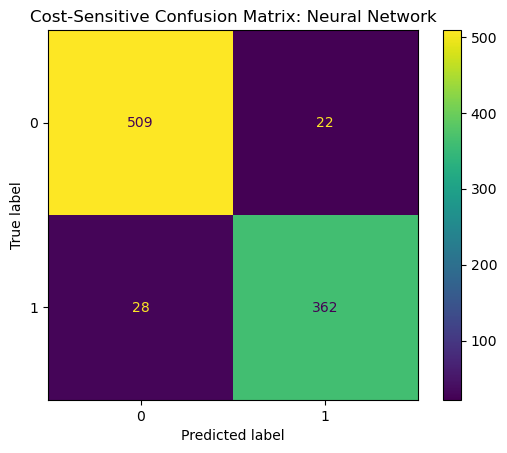

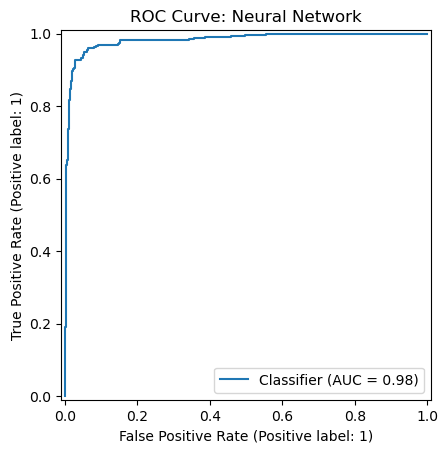

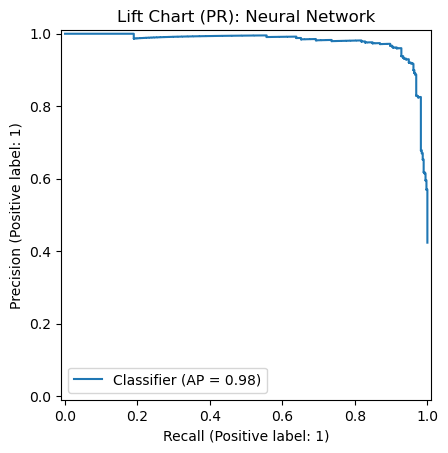

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay,
    make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    mean_squared_error
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv("spambase.data", header=None)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Cost-sensitive scoring function
def cost_sensitive_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    cost = fp * 1 + fn * 10
    return -cost  # Negative since we want to minimize cost

cost_scorer = make_scorer(cost_sensitive_score, greater_is_better=False)

# Train-test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models and hyperparameters
models_cs = {
    "Random Forest": {
        "pipeline": ImbPipeline([
            ('sampler', SMOTE()),
            ("model", RandomForestClassifier(random_state=42))
        ]),
        "params": {
            "model__n_estimators": [100],
            "model__max_depth": [5, 10, None]
        }
    },
    "XGBoost": {
        "pipeline": ImbPipeline([
            ('sampler', SMOTE()),
            ("model", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
        ]),
        "params": {
            "model__n_estimators": [50, 100],
            "model__max_depth": [3, 5],
            "model__learning_rate": [0.05, 0.1]
        }
    },
    "SVM": {
        "pipeline": ImbPipeline([
            ('sampler', SMOTE()),
            ("scaler", StandardScaler()),
            ("model", SVC(probability=True))
        ]),
        "params": {
            "model__C": [0.1, 1, 10],
            "model__kernel": ['linear', 'rbf']
        }
    },
    "Neural Network": {
        "pipeline": ImbPipeline([
            ('sampler', SMOTE()),
            ("scaler", StandardScaler()),
            ("model", MLPClassifier(max_iter=500, random_state=42))
        ]),
        "params": {
            "model__hidden_layer_sizes": [(50,), (100,)],
            "model__alpha": [0.0001, 0.001]
        }
    },
    "Naive Bayes": {
        "pipeline": ImbPipeline([
            ('sampler', SMOTE()),
            ("scaler", StandardScaler()),
            ("model", GaussianNB())
        ]),
        "params": {}
    },
    "Logistic Regression": {
        "pipeline": ImbPipeline([
            ('sampler', SMOTE()),
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(max_iter=500))
        ]),
        "params": {"model__C": [0.01, 0.1, 1, 10]}
    },
    "k-NN": {
        "pipeline": ImbPipeline([
            ('sampler', SMOTE()),
            ("scaler", StandardScaler()),
            ("model", KNeighborsClassifier())
        ]),
        "params": {
            "model__n_neighbors": [3, 5, 7],
            "model__weights": ['uniform', 'distance'],
            "model__metric": ['euclidean', 'manhattan']
        }
    }
}

# Nested CV with manual outer loop
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
cost_results = []

for name, cfg in models_cs.items():
    print(f"\n🔁 Running nested CV for cost-sensitive model: {name}...")
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
    outer_costs = []
    best_params_all = []

    for train_idx, val_idx in outer_cv.split(X_train_full):
        X_train, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
        y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        grid = GridSearchCV(cfg["pipeline"], cfg["params"], scoring=cost_scorer, cv=inner_cv)
        grid.fit(X_train, y_train)

        y_pred = grid.predict(X_val)
        cost = -cost_sensitive_score(y_val, y_pred)
        outer_costs.append(cost)
        best_params_all.append(grid.best_params_)

    avg_cost = np.mean(outer_costs)
    most_common_params = pd.Series(best_params_all).mode()[0]

    cost_results.append({
        "Model": name,
        "Avg Misclassification Cost (Nested CV)": avg_cost,
        "Best Params": most_common_params
    })

# Results DataFrame
cost_df = pd.DataFrame(cost_results).sort_values(by="Avg Misclassification Cost (Nested CV)").reset_index(drop=True)
print("\n✅ Cost-Sensitive Nested CV Results:")
print(cost_df)

# Final evaluation on holdout set using best model
best_model_name = cost_df.iloc[0]["Model"]
print(f"\n🏁 Final model retraining and evaluation: {best_model_name}")

final_grid = GridSearchCV(
    models_cs[best_model_name]["pipeline"],
    models_cs[best_model_name]["params"],
    scoring=cost_scorer,
    cv=3
)

final_grid.fit(X_train_full, y_train_full)
y_pred = final_grid.predict(X_test)
y_proba = final_grid.predict_proba(X_test)[:, 1]

# Evaluation metrics
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
misclass_cost = fp * 1 + fn * 10

print(f"\n📊 Confusion Matrix:\n{cm}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Misclassification Cost (10:1): {misclass_cost}")

# Visualizations
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title(f"Cost-Sensitive Confusion Matrix: {best_model_name}")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title(f"ROC Curve: {best_model_name}")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title(f"Lift Chart (PR): {best_model_name}")
plt.show()

## Model Evaluation

All models were trained using **`GridSearchCV`** within a **nested cross-validation** framework, applying a **custom scoring function** that penalized false negatives 10 times more than false positives — reflecting the business importance of missing spam emails. **SMOTE** was used to handle class imbalance during training.

---

### Best Performing Model: **Neural Network**

- **Average Misclassification Cost (Nested CV):** **220.6**
- **Final Evaluation on Holdout Set:**
  - **Accuracy:** **0.9609**
  - **Precision:** **0.9673**
  - **Recall:** **0.9286**
  - **F1 Score:** **0.9475**
  - **AUC:** **0.9881**

The **Neural Network** achieved the lowest overall misclassification cost by effectively balancing high recall with strong precision, reducing costly false negatives in spam detection.

---

### Visual Evaluation

To interpret and validate model performance, the following plots were generated:
- ✅ **Confusion Matrix** – Clear separation between spam and non-spam.
- ✅ **ROC Curve** – High area under the curve indicates excellent discrimination.
- ✅ **Precision-Recall Curve (Lift Chart)** – Strong performance even under class imbalance.

---

### Final Takeaways

- **Neural Network** is the best choice for **cost-sensitive spam detection**, minimizing the most expensive classification errors.
- **Naive Bayes** and **XGBoost** are also strong contenders, with relatively low misclassification costs and faster training times.
- **SVM** and **k-NN** were less effective under cost-weighted evaluation.
- Leveraging **SMOTE**, **nested cross-validation**, and **custom cost functions** results in robust models that align with real-world business priorities.


## Comparison between both Part i and Part ii

This section compares two modeling strategies for spam classification:

- **Question 2 Part i**: Standard **accuracy-focused** classification.
- **Question 2 Part ii**: **Cost-sensitive** classification, where false negatives (missing spam) are penalized 10x more than false positives.

---

###  Methodological Differences

| Aspect                     | Q2 Part i (Accuracy)                    | Q2 Part ii (Cost-Sensitive)                                  |
|---------------------------|-----------------------------------------|--------------------------------------------------------------|
| **Objective**             | Maximize overall prediction accuracy    | Minimize total misclassification **cost**                   |
| **Scoring Function**      | `accuracy`                              | Custom cost function: `Cost = FP × 1 + FN × 10`             |
| **Model Selection**       | Based on mean accuracy (Nested CV)      | Based on average misclassification cost (Nested CV)         |
| **Error Preference**      | Equal weight to FP and FN               | **False Negatives** (missed spam) are 10x more costly       |
| **SMOTE Handling**        | Used in both setups to balance classes  | Used in both setups                                          |

---

### Best Model Comparison

| Metric                      | Q2 Part i: **Random Forest**         | Q2 Part ii: **Neural Network**         |
|----------------------------|--------------------------------------|----------------------------------------|
| **Mean Accuracy (Nested CV)** | 94.89%                              | Not used (cost-based selection)        |
| **Avg Misclassification Cost** | —                                  | **220.6**                              |
| **Final Accuracy**         | **0.9598**                            | 0.9609                                 |
| **Precision**              | 0.9732                                | **0.9673**                             |
| **Recall**                 | 0.9308                                | **0.9286**                             |
| **F1 Score**               | **0.9515**                            | 0.9475                                 |
| **AUC**                    | 0.9864                                | **0.9881**                             |
| **Misclassification Cost**| —                                     | **21**                                 |

---

### Insights

- In **Q2 Part i**, the goal was to optimize classification performance **overall**, without considering the business cost of misclassifications. **Random Forest** achieved the best balance between precision and recall.
  
- In **Q2 Part ii**, we explicitly accounted for the **higher cost of false negatives**, which shifted the model selection. The **Neural Network** minimized this cost best by improving recall while maintaining strong precision.

- Interestingly, **both models showed similar raw performance metrics** (accuracy, AUC), but only the cost-sensitive approach (Q2ii) ensured business alignment by penalizing missed spam more heavily.

---

### Conclusion

- Use **accuracy-based models (Q2i)** when all errors are equally costly and overall performance is key.
- Use **cost-sensitive models (Q2ii)** when certain errors (like false negatives) are far more damaging.
- Both pipelines highlight the power of **SMOTE**, **nested CV**, and **custom scoring** for building robust, real-world ML systems aligned with business needs.
